In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import sklearn
import random
import time
import numpy as np

In [2]:
import IPython
import warnings
from IPython import display
warnings.filterwarnings('ignore')
from subprocess import check_output

In [56]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn import model_selection

In [38]:
from xgboost import XGBClassifier

In [39]:
import matplotlib as mpl
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

In [40]:
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [41]:
data_row = pd.read_csv('train.csv')

In [42]:
data_val = pd.read_csv('test.csv')

In [43]:
data1 = data_row.copy(deep=True)

In [44]:
sub_com = pd.read_csv('my_solution_ver2.csv')

In [45]:
data_val['Survived'] = sub_com['Survived']

In [46]:
data_val.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [47]:
data_cleaner = [data1, data_val]

In [48]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [49]:
print('Null value in data1:\n', data1.isnull().sum())

Null value in data1:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [50]:
for dataset in data_cleaner:
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
    
print(data1.isnull().sum())
print("-"*10)
print(data_val.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
Survived         0
dtype: int64


In [51]:
for dataset in data_cleaner:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0
    dataset['Title'] = dataset['Name'].str.split(",", expand=True)[1].str.split(".", expand=True)[0]
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)
    
stat_min = 10
title_names = (data1['Title'].value_counts() < stat_min)
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] ==True else x)

print(data1['Title'].value_counts())
print("-"*10)

 Mr        517
 Miss      182
 Mrs       125
 Master     40
Misc        27
Name: Title, dtype: int64
----------


In [52]:
label = LabelEncoder()

for dataset in data_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    
Target = ['Survived']

data1_x = ['Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']
data1_x_calc = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'SibSp', 'Parch', 'Age', 'Fare']
data1_xy = Target + data1_x
print('Original X Y: ', data1_xy, '\n')

data1_x_bin = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')

data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')

data1_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_ Master', 'Title_ Miss', 'Title_ Mr', 'Title_ Mrs', 'Title_Misc'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,Title_Misc
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,1,0,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,1,0
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,1,0,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,1,0
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,1,0,0


In [57]:
train1_x, test1_x, train1_y,  test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target], random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)

print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

Data1 Shape: (891, 22)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,2,1,1,0
68,0,3,2,1,7,1,1
253,1,3,2,2,2,1,2
320,1,3,2,2,1,1,0
706,0,2,2,3,1,2,1


In [55]:
for x in data1_x:
    if data1[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')
        
print(pd.crosstab(data1['Title'],data1[Target[0]]))

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by: Title
     Title  Survived
0   Master  0.575000
1     Miss  0.697802
2       Mr  0.156673
3      Mrs  0.792000
4     Misc  0.444444
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303

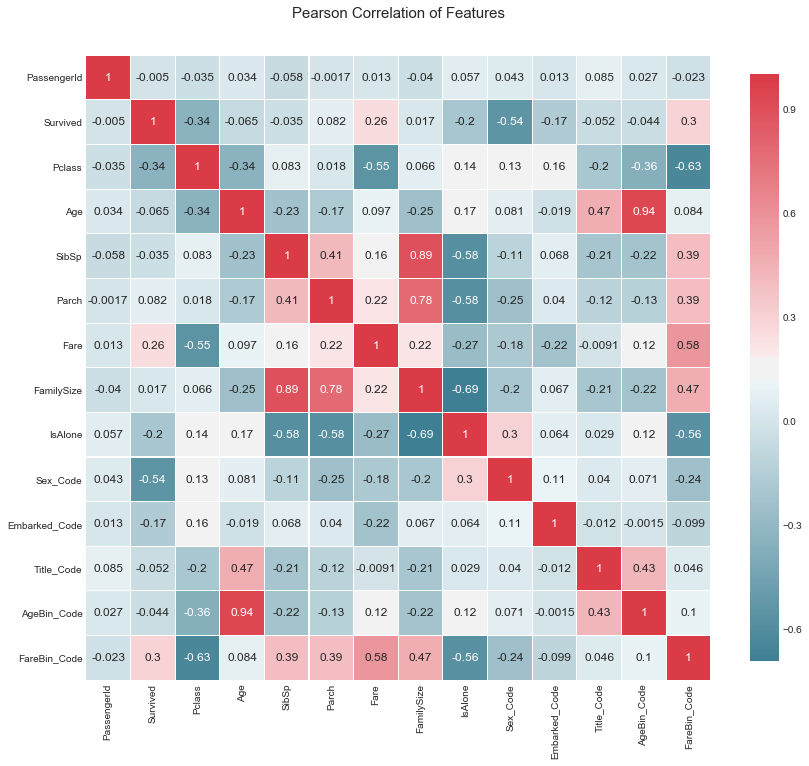

In [29]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data1)

In [69]:
xg_boost = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.65, gamma=2, learning_rate=0.3, max_delta_step=1,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=280,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

(223, 7)

In [73]:
train1_x_bin.head()

,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,2,1,1,0
68,0,3,2,1,7,1,1
253,1,3,2,2,2,1,2
320,1,3,2,2,1,1,0
706,0,2,2,3,1,2,1


In [87]:
xg_boost.fit(train1_x_bin, train1_y_bin)
y_pred = xg_boost.predict(data_val[data1_x_bin])
print(xg_boost.score(train1_x_bin, train1_y_bin))

scores = model_selection.cross_val_score(xg_boost, train1_x_bin, train1_y_bin, cv=5, scoring='accuracy')
print(scores)
print("Kfold on XGBClassifier: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

0.8458083832335329
[0.82835821 0.8358209  0.82089552 0.80451128 0.83458647]
Kfold on XGBClassifier: 0.8248 (+/- 0.0115)


In [88]:
titanic_sub_xgb = pd.DataFrame(data_val, columns=['PassengerId','Survived'])
titanic_sub_xgb['Survived'] = y_pred

In [106]:
titanic_sub_xgb.to_csv('titanic_sub2_xgb', index=False)